<a href="https://colab.research.google.com/github/samiha-mahin/Ovarian-cancer/blob/main/HT_DenseNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle tensorflow numpy pandas opencv-python matplotlib scikit-learn

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samihamuntahamahin","key":"1ad5aaba9143fbd38da418ad8d278398"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset
!kaggle datasets download -d bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology --unzip

Dataset URL: https://www.kaggle.com/datasets/bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology
License(s): CC-BY-SA-4.0


In [ ]:
# Import libraries
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Dataset and config
DATASET_PATH = "OvarianCancer"
classes = ["Mucinous", "Non_Cancerous", "Endometri", "Serous", "Clear_Cell"]
class_mapping = {cls: i for i, cls in enumerate(classes)}
IMG_SIZE = 224

# Load and preprocess images
X, y = [], []
for cls in classes:
    class_path = os.path.join(DATASET_PATH, cls)
    if not os.path.exists(class_path): continue
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path)
        if img is None: continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = tf.keras.applications.densenet.preprocess_input(img)
        X.append(img)
        y.append(class_mapping[cls])

X = np.array(X)
y = to_categorical(y, num_classes=len(classes))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = datagen.flow(X_train, y_train, batch_size=32)

# Load DenseNet121
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Unfreeze deeper layers
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Custom top layers
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(len(classes), activation='softmax')(x)

# Model
model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint("best_model_densenet121.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Train
history = model.fit(
    train_generator,
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=callbacks
)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.2580 - loss: 2.0722 
Epoch 1: val_accuracy improved from -inf to 0.40000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 447s 26s/step - accuracy: 0.2630 - loss: 2.0553 - val_accuracy: 0.4000 - val_loss: 1.3955 - learning_rate: 1.0000e-04
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.4431 - loss: 1.3759 
Epoch 2: val_accuracy improved from 0.40000 to 0.59000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 370s 25s/step - accuracy: 0.4476 - loss: 1.3657 - val_accuracy: 0.5900 - val_loss: 1.1493 - learning_rate: 1.0000e-04
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.6190 - loss: 0.9539 
Epoch 3: val_accuracy improved from 0.59000 to 0.64000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 338s 26s/step - accuracy: 0.6227 - loss: 0.9495 - val_accuracy: 0.6400 - val_loss: 1.0257 - learning_rate: 1.0000e-04
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.7334 - loss: 0.7764 
Epoch 4: val_accuracy improved from 0.64000 to 0.69000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 331s 27s/step - accuracy: 0.7350 - loss: 0.7719 - val_accuracy: 0.6900 - val_loss: 0.9164 - learning_rate: 1.0000e-04
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.8090 - loss: 0.5400 
Epoch 5: val_accuracy improved from 0.69000 to 0.71000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 336s 26s/step - accuracy: 0.8092 - loss: 0.5417 - val_accuracy: 0.7100 - val_loss: 0.8522 - learning_rate: 1.0000e-04
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.8247 - loss: 0.5263 
Epoch 6: val_accuracy improved from 0.71000 to 0.74000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 328s 25s/step - accuracy: 0.8250 - loss: 0.5249 - val_accuracy: 0.7400 - val_loss: 0.7775 - learning_rate: 1.0000e-04
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.8161 - loss: 0.4847 
Epoch 7: val_accuracy improved from 0.74000 to 0.77000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 321s 25s/step - accuracy: 0.8167 - loss: 0.4840 - val_accuracy: 0.7700 - val_loss: 0.6929 - learning_rate: 1.0000e-04
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.8675 - loss: 0.3493 
Epoch 8: val_accuracy improved from 0.77000 to 0.80000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 321s 25s/step - accuracy: 0.8672 - loss: 0.3502 - val_accuracy: 0.8000 - val_loss: 0.6157 - learning_rate: 1.0000e-04
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.8493 - loss: 0.4175 
Epoch 9: val_accuracy did not improve from 0.80000
13/13 ━━━━━━━━━━━━━━━━━━━━ 319s 24s/step - accuracy: 0.8507 - loss: 0.4159 - val_accuracy: 0.8000 - val_loss: 0.6016 - learning_rate: 1.0000e-04
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.9182 - loss: 0.2788 
Epoch 10: val_accuracy improved from 0.80000 to 0.85000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 318s 26s/step - accuracy: 0.9179 - loss: 0.2784 - val_accuracy: 0.8500 - val_loss: 0.4956 - learning_rate: 1.0000e-04
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.9186 - loss: 0.2614 
Epoch 11: val_accuracy did not improve from 0.85000
13/13 ━━━━━━━━━━━━━━━━━━━━ 321s 24s/step - accuracy: 0.9183 - loss: 0.2611 - val_accuracy: 0.8500 - val_loss: 0.4632 - learning_rate: 1.0000e-04
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.9353 - loss: 0.1999 
Epoch 12: val_accuracy did not improve from 0.85000
13/13 ━━━━━━━━━━━━━━━━━━━━ 315s 24s/step - accuracy: 0.9335 - loss: 0.2028 - val_accuracy: 0.8400 - val_loss: 0.5328 - learning_rate: 1.0000e-04
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.9326 - loss: 0.2032 
Epoch 13: val_accuracy improved from 0.85000 to 0.87000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 353s 27s/step - accuracy: 0.9328 - loss: 0.2026 - val_accuracy: 0.8700 - val_loss: 0.4228 - learning_rate: 1.0000e-04
Epoch 14/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.9467 - loss: 0.1594 
Epoch 14: val_accuracy improved from 0.87000 to 0.89000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 333s 26s/step - accuracy: 0.9467 - loss: 0.1595 - val_accuracy: 0.8900 - val_loss: 0.3654 - learning_rate: 1.0000e-04
Epoch 15/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.9540 - loss: 0.1416 
Epoch 15: val_accuracy did not improve from 0.89000
13/13 ━━━━━━━━━━━━━━━━━━━━ 333s 26s/step - accuracy: 0.9530 - loss: 0.1437 - val_accuracy: 0.8500 - val_loss: 0.4546 - learning_rate: 1.0000e-04
Epoch 16/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.9435 - loss: 0.1466 
Epoch 16: val_accuracy did not improve from 0.89000
13/13 ━━━━━━━━━━━━━━━━━━━━ 334s 26s/step - accuracy: 0.9438 - loss: 0.1464 - val_accuracy: 0.8600 - val_loss: 0.4439 - learning_rate: 1.0000e-04
Epoch 17/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.9469 - loss: 0.1653 
Epoch 17: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 17: val_accuracy did not improve from 0.89000
13/13 ━━━━━━━━━━━━━━━━━━━━ 372s 25s/step - accuracy: 0.9478 - loss: 0.163

13/13 ━━━━━━━━━━━━━━━━━━━━ 325s 25s/step - accuracy: 0.9696 - loss: 0.1153 - val_accuracy: 0.9100 - val_loss: 0.3399 - learning_rate: 2.5000e-05
Epoch 22/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.9582 - loss: 0.1068 
Epoch 22: val_accuracy improved from 0.91000 to 0.92000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 326s 25s/step - accuracy: 0.9588 - loss: 0.1060 - val_accuracy: 0.9200 - val_loss: 0.3215 - learning_rate: 2.5000e-05
Epoch 23/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.9778 - loss: 0.0773 
Epoch 23: val_accuracy did not improve from 0.92000
13/13 ━━━━━━━━━━━━━━━━━━━━ 325s 25s/step - accuracy: 0.9778 - loss: 0.0772 - val_accuracy: 0.9200 - val_loss: 0.3161 - learning_rate: 2.5000e-05
Epoch 24/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.9731 - loss: 0.1056 
Epoch 24: val_accuracy did not improve from 0.92000
13/13 ━━━━━━━━━━━━━━━━━━━━ 324s 25s/step - accuracy: 0.9740 - loss: 0.1033 - val_accuracy: 0.9100 - val_loss: 0.3108 - learning_rate: 2.5000e-05
Epoch 25/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.9834 - loss: 0.0660 
Epoch 25: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 25: val_accuracy did not improve from 0.92000
13/13 ━━━━━━━━━━━━━━━━━━━━ 325s 25s/step - accuracy: 0.9833 - loss: 0.066

In [ ]:
# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f" Final Test Accuracy: {accuracy*100:.2f}%")
print(f" Final Test Loss: {loss:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.9076 - loss: 0.4025
 Final Test Accuracy: 92.00%
 Final Test Loss: 0.3215


In [ ]:
# Save model
model.save("densenet121_ovarian_cancer_final_model.h5")
print(" Model saved!")

 Model saved!


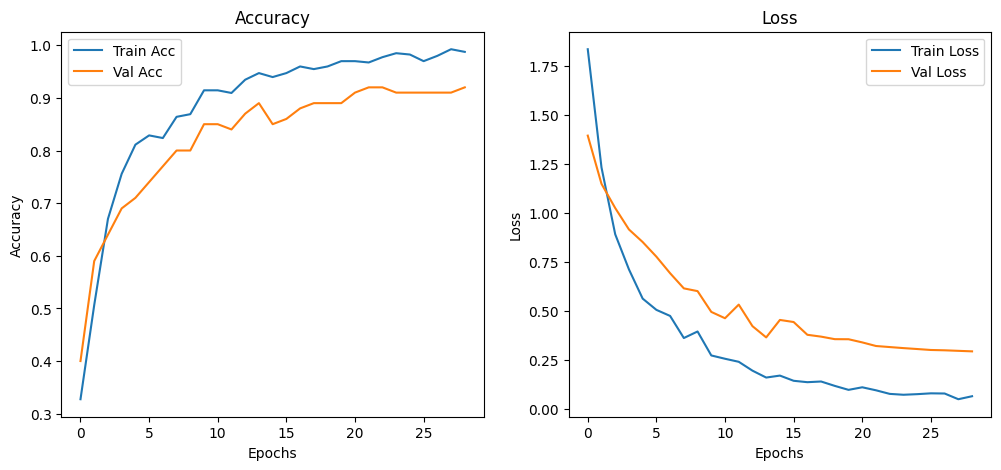

In [ ]:
# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend(); plt.title("Accuracy"); plt.xlabel("Epochs"); plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss"); plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.show()

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd # Import the pandas library

4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step


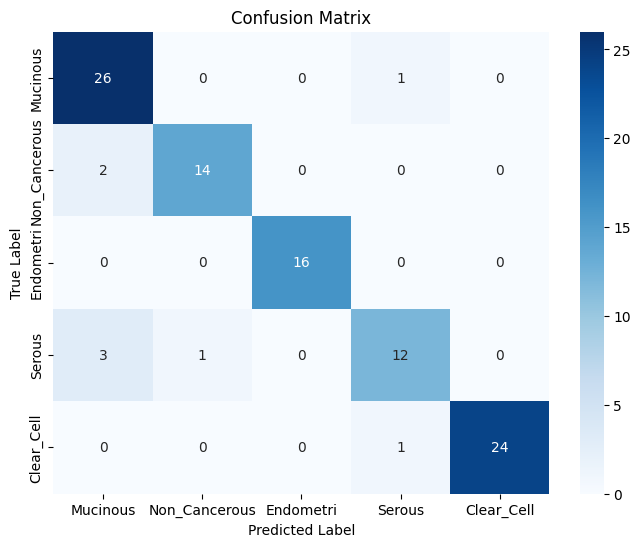

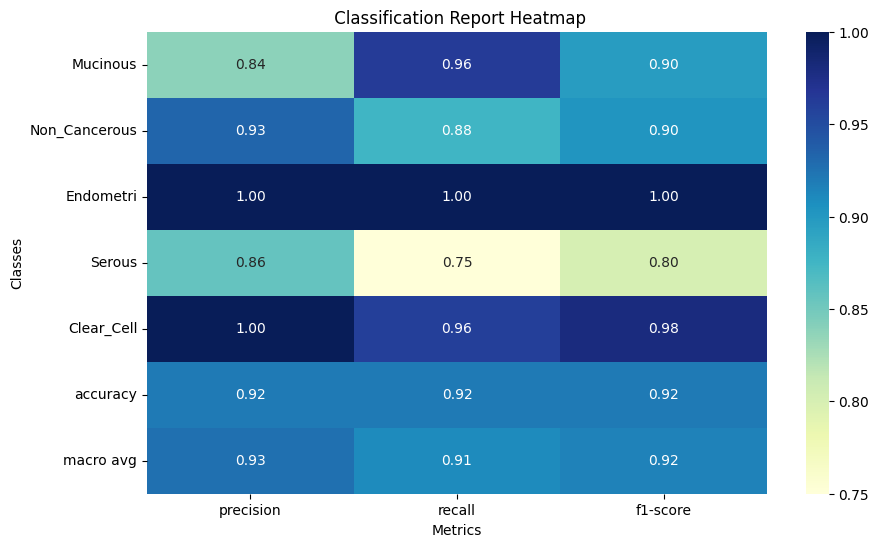

In [ ]:
# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification Report as heatmap
report = classification_report(y_true, y_pred_classes, target_names=classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(10,6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title(" Classification Report Heatmap")
plt.ylabel("Classes")
plt.xlabel("Metrics")
plt.show()
